# Association Mining!

The problem - How do you determine which items belong together from data? 
For example imagine you are running a store and you want to know what items are frequently bought together - how would you go about this in an automated and systematic way?

Apriori algorithm
* pro: Easy to implement, easy to parallelize
* con: Computationally expensive


Market basket analysis
 * Better shop layout
 * Adverse effects of combining medicine

Association rules are generally in the `if ... then ...` format. E.g:

> If a customer buys milk and butter then they buy bread.

In formal logic this is called an implication, and is generally denoted with an arrow, so the statement above could be written:

> `{milk, butter} -> bread`





Rule constraints 
* Support - of an item set X is the proportion of observations in the dataset where X occurs
    * $supp(X) = \frac{\text{# observations with X}}{\text{Total # transactions}}$
* Confidence - How strong is the rule? I.e. the confidence for `X->Y` is the likelihood that `Y` is purchased, if `X` is purchased. 
This is the same as the conditional probability.
It is defined as follows:
    * $conf(X \rightarrow Y) = \frac{supp(X \cup Y)}{supp(X)}$
* Lift
    * Drawback with confidence: if the support for `Y` is very high, then the confidence of `X->Y` might not be very informative.
    * $lift(X\rightarrow Y) = \frac{supp(X \cup Y)}{supp(X) supp(Y)}$
* Conviction
    * $conv(X \rightarrow Y) = \frac{1-supp(Y)}{1-conf(X->Y)}$
    * ??? How much better than chance is this association?


Example work
1. Load data
1. Create itemsets of one-hot DataFrame
1. Determine minimum support (and confidence) threshold
    1. Some data exploration 
1. Find all items that satisfies this support threshold
1. Find all combinations of the items that satisfy the support threshold. You can use arbitrarily large sets.



In [1]:
# Makes matplotlib plots work better with Jupyter
%matplotlib inline

# Import the necessary libraries. 
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pprint import pprint
from itertools import combinations


# The Data

For this exercise we will be working with classical shopping-cart data.
The cell below loads the data and prints the first example.

In [4]:
# Check that data and data path is present
data_folder = "../data/"
data_filename = "shopping.json"
assert os.path.isdir(data_folder) and os.path.exists(data_folder + data_filename), 'Data not found. Make sure to have the most recent version!'

with open(data_folder + data_filename) as f:
    data_raw = json.load(f)

print('Number of observations', len(data_raw))
pprint(data_raw[0])

Number of observations 1499
{'date': '1/1/2000',
 'items': ['yogurt',
           'pork',
           'sandwich bags',
           'lunch meat',
           'all- purpose',
           'flour',
           'soda',
           'butter',
           'vegetables',
           'beef',
           'aluminum foil',
           'all- purpose',
           'dinner rolls',
           'shampoo',
           'all- purpose',
           'mixes',
           'soap',
           'laundry detergent',
           'ice cream',
           'dinner rolls',
           '']}


AttributeError: 'list' object has no attribute 'describe'

## Task 1: Transforming the Data
> Estimated task time: 10 min

The first thing we want to do is transform the data into a one-hot matrix.
A one-hot matrix is a matrix where each column represent an item, e.g. `ice cream`, and each row represents a transaction.
`0` indicates the item wasn't bought, and `1` indicates that it was.

Your task is to
1. Create a list of all the feature names, but remove the uninformative ones, i.e. the ones in `bad_feature_names`
1. Create a one-hot numpy array of the data, and name it `data`
 * Note: If an item occurs twice in a transaction we still just want to have a `1` in the one-hot matrix.
 * Hint: The array should have shape `(1499, 37)`
 

In [5]:
num_obs = len(data_raw)
bad_feature_names = ['', 'all- purpose']

data = None ## YOUR CODE HERE 

# Make a list of all the items
all_items = []
for i in range(num_obs):
    all_items += data_raw[i]['items']
    
# Find the unique item names
features_names = list(np.unique(all_items))

# Remove bad item names
for bad_feature in bad_feature_names:
    features_names.remove(bad_feature)

print('feature_names')
print(features_names)
print()
# Create a one-hot matrix
num_features = len(features_names)
data = np.zeros([num_obs, num_features])
for i in range(num_obs):
    for item in data_raw[i]['items']:
        if item not in bad_feature_names:
            j = features_names.index(item)
            data[i,j] = 1

print('The data looks like this now:')


feature_names
['aluminum foil', 'bagels', 'beef', 'butter', 'cereals', 'cheeses', 'coffee/tea', 'dinner rolls', 'dishwashing liquid/detergent', 'eggs', 'flour', 'fruits', 'hand soap', 'ice cream', 'individual meals', 'juice', 'ketchup', 'laundry detergent', 'lunch meat', 'milk', 'mixes', 'paper towels', 'pasta', 'pork', 'poultry', 'sandwich bags', 'sandwich loaves', 'shampoo', 'soap', 'soda', 'spaghetti sauce', 'sugar', 'toilet paper', 'tortillas', 'vegetables', 'waffles', 'yogurt']

The data looks like this now:
[[1. 0. 1. ... 1. 0. 1.]
 [1. 0. 0. ... 1. 1. 1.]
 [0. 1. 0. ... 1. 0. 0.]
 ...
 [0. 1. 1. ... 1. 0. 1.]
 [0. 0. 1. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 0. 0.]]


AttributeError: 'numpy.ndarray' object has no attribute 'describe'

## Task 2: Compute the Support

> Estimated task time: 10 min

Now we want to compute the support of each of the individual items, and visualize it.

Your job:
1. Finish the `compute_support` function - which computes the support for one combination of items. 
 * E.g. `(0,1,2)` would be `{'aluminum foil', 'bagels', 'beef',}`, which occurs 7.20% of the time.
1. Compute the support of each of the items individually - i.e. how frequent are each item.
1. Visualize the support as a histogram.
    * Hint: `plt.xticks` can be used to rotate the labels on the x-axis for a prettier plot.

Support for (0,1,2): 0.07204803202134756


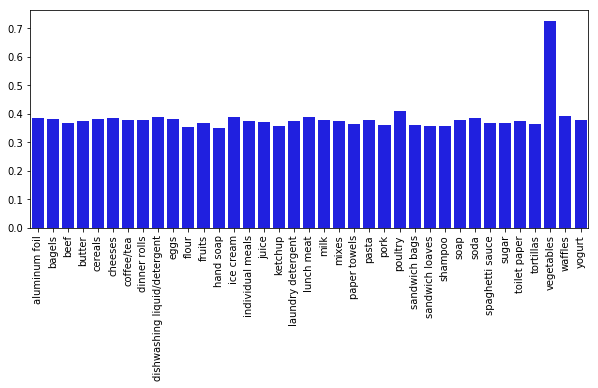

In [6]:
def compute_support(X, combi):
    """ Given a one-hot array X, and a tuple, combi, indicating the columns of interest
        compute_support returns the support of the elements in combi.
    """
    
    ## YOUR CODE HERE
    rule = X[:, combi].all(axis=1)
    support = rule.sum() / X.shape[0]
    return support

print('Support for (0,1,2):', compute_support(data, (0,1,2)))

support = []
for i in range(data.shape[1]):
    support.append(compute_support(data, (i,)))

plt.figure(figsize=(10,4))
g = sns.barplot(x=features_names, y=support, color='b')
plt.xticks(rotation=90)
plt.show()

## Task 3: Creating Combinations
> Estimated task time: 10 min

Here we want to implement and test a helper function `candidate_generation`.
The function takes a `NxM` numpy array of item sets.
`N` indicates the number of item sets, and `M` indicates the length.
The function should then produce a [generator](https://medium.freecodecamp.org/how-and-why-you-should-use-python-generators-f6fb56650888) that generates all relevant new item set combinations of length `M+1`.

Your task:
1. Fill out the function `candidate_generation`. The output must be as a tuple.
 * Note: Watch out you don't create duplicates! We don't care about the order, so `(0, 1)` is the same as `(1, 0)`.
 * Hint: It is a good idea to start by finding all the unique values in old_combinations.
1. Run the test in the next cell, and make sure that you get the correct result.

In [8]:
def candidate_generation(old_combinations):
    """ Input: An NxM array of item sets, 
            N: number of combinations
            M: length of each item set
        Output: A generator that produces all possible combinations 
    """
    
    ## YOUR CODE HERE 
    items_types_in_previous_step = np.unique(old_combinations.flatten())
    
    for old_combination in old_combinations:
        max_combination = max(old_combination)
        for item in items_types_in_previous_step:
            if item > max_combination:
                res = tuple(old_combination) + (item,)
                yield res

The cell below serves as a test of `candidate_generation`. 
If your function is written correctly the output shold be as follows:

    [[0 1 2 3]]

    [[0 0 0 1 1 2]
     [1 2 3 2 3 3]]

    [[0 0 0 1]
     [1 1 2 2]
     [2 3 3 3]]

    [[0]
     [1]
     [2]
     [3]]


In [9]:
# Test of candidate_generation
comb = np.array([[0],[1],[2],[3]])
print(comb.T)
print()

new_comb = []
for c in candidate_generation(comb):
    new_comb.append(c)
comb = np.array(new_comb)
print(comb.T)
print()

new_comb = []
for c in candidate_generation(comb):
    new_comb.append(c)
comb = np.array(new_comb)
print(comb.T)
print()

new_comb = []
for c in candidate_generation(comb):
    new_comb.append(c)
comb = np.array(new_comb)
print(comb.T)

[[0 1 2 3]]

[[0 0 0 1 1 2]
 [1 2 3 2 3 3]]

[[0 0 0 1]
 [1 1 2 2]
 [2 3 3 3]]

[[0]
 [1]
 [2]
 [3]]


## Task 4: Finding the Right Sets 
> Estimated task time: 25 min

In this task we will find all the sets that have sufficient support.


Your task:
1. Finish the code below using what you have already done in the previous tasks. Each iteration of the loop should:
 * Generate all relevant combinations.
 * For each combination compute the support
 * If the support is larger than `min_support` save the item set and the support in `itemset_dict` and `support_dict`.
1. Convert your results, `itemset_dict` and `support_dict`, into a `pandas` dataframe.
 * Use `reset_index` to fix the indexes (remove the unwanted 'history')
1. Find an appropriate minimum support (subjective). Run the code several times, and see how changing this value changes the outcome.
 * You may choose a maximum length as well if you want to.
1. Print the results using the actual feature names - how does it look? Any surprises?

In [ ]:
min_support = 0.3

# Compute / re-compute support, and set it up as a dictionary 
support = []
for i in range(data.shape[1]):
    support.append(compute_support(data, (i,)))
support = np.asarray(support)
support_dict = {1: support[support >= min_support]}

# Setup all the attomic items in a dict.
ary_col_idx = np.arange(data.shape[1])
itemset_dict = {1: ary_col_idx[support >= min_support].reshape(-1, 1)}
rows_count = float(data.shape[0])

itemset_len = 1
while itemset_len:
    pass
    
    ## YOUR CODE HERE 
    next_itemset_len = itemset_len + 1
    combin = candidate_generation(itemset_dict[itemset_len])
    frequent_items = []
    frequent_items_support = []

    for c in combin:
        support = compute_support(data, c)
        
        if support >= min_support:
            frequent_items.append(c)
            frequent_items_support.append(support)

    if frequent_items:
        itemset_dict[next_itemset_len] = np.array(frequent_items)
        support_dict[next_itemset_len] = np.array(frequent_items_support)
        itemset_len = next_itemset_len
    else:
        itemset_len = 0


all_res = []
for k in sorted(itemset_dict):
    support = pd.Series(support_dict[k])
    itemsets = pd.Series([frozenset(i) for i in itemset_dict[k]])

    res = pd.concat((support, itemsets), axis=1)
    all_res.append(res)

res_df = pd.concat(all_res)
res_df.columns = ['support', 'itemsets']
res_df = res_df.reset_index(drop=True)


# Print results in a human readable manner
for i in range(37, len(res_df)):
    print([features_names[i] for i in res_df.itemsets[i]], 'has support', res_df.support[i])


## Task 
> Estimated task time:  min

Your tasks
* Choose whether you want to use support, confidence, lift, or conviction as your decision metric, and choose a minimum threshold.


In [ ]:
columns_ordered = ['antecedents', 'consequents',
                   'antecedent support', 'consequent support',
                   'support',
                   'confidence', 'lift', 'leverage', 'conviction']

keys = res_df['itemsets'].values
values = res_df['support'].values

min_threshold = 0.1

frozenset_vect = np.vectorize(lambda x: frozenset(x))
frequent_items_dict = dict(zip(frozenset_vect(keys), values))

# prepare buckets to collect frequent rules
rule_antecedents = []
rule_consequents = []
rule_supports = []


# iterate over all frequent itemsets
for k in frequent_items_dict.keys():
    sAC = frequent_items_dict[k]
    # to find all possible combinations
    for idx in range(len(k)-1, 0, -1):
        # of antecedent and consequent
        for c in combinations(k, r=idx):
            antecedent = frozenset(c)
            consequent = k.difference(antecedent)

            sA = frequent_items_dict[antecedent]
            sC = frequent_items_dict[consequent]

#             score = metric_dict[metric](sAC, sA, sC)
            confidence = None
            lift = None
            conviction = None
            score = 1
            if score >= min_threshold:
                rule_antecedents.append(antecedent)
                rule_consequents.append(consequent)
                rule_supports.append([sAC, sA, sC])

# generate metrics
rule_supports = np.array(rule_supports).T.astype(float)
df_res = pd.DataFrame(
    data=list(zip(rule_antecedents, rule_consequents)),
    columns=["antecedents", "consequents"])

sAC = rule_supports[0]
sA = rule_supports[1]
sC = rule_supports[2]


# TODO
df_res['total_support'] = 0
df_res['antecedent_support'] = 0
df_res['consequent_support'] = 0
df_res['confidence'] = 0
df_res['lift'] = 0
df_res['conviction'] = 0



In [ ]:
df_res

## Task 
> Estimated task time:  min
